<div class="alert alert-block alert-info">
    
<h1 style="color:Blue;"> <center> <ins> <b> 
Métodos Numéricos - Projeto Final 
</b> </ins> </center> </h1>
    
<h3 style="color:Blue;"> <center> <b> 
Análise de Imagens de Tomografia Computadorizada de Pulmões - Projeto completo
</b></center> </h3>
    
<h4 style="color:Blue;"> <center> <b> 
ALUNO: Gabriel da Silva Nascimento
</b></center> </h4>

</div>

<div class="alert alert-block alert-info" style="color:Blue;" id="descricao">
Descrição do Projeto
</div>

Nessa parte do projeto final, vocês usarão parte do que aprenderam para fazer uma análise completa usando processamento de imagens de pulmões, basicamente com o uso das bibliotecas com as quais lidamos nas partes anteriores.

A tarefa aqui é bem simples: executar, logicamente inserindo os comentários sobre os resultados obitidos e os códigos associados, o tutorial intitulado [Introduction to medical image processing with Python: CT lung and vessel segmentation without labels](https://theaisummer.com/medical-image-python/).



## Bibliotecas

In [1]:
import os
import csv
import glob
import shutil
import numpy as np
import nibabel as nib
from skimage import measure
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull

### Funções Auxiliares

In [2]:
def show_slice(slice):
    """
    Display an image slice
    
    Args:
        slice (np.array): image slice
    """
    
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")

def overlay_plot(im, mask):
    """
    Display an image slice and mask
    
    Args:
        im (np.array): image slice
        mask (list): mask value list
    """
    
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)

def make_dirs(path):
    """
    Creates the directory as specified from the path in case it exists it deletes it
    
    Args:
        path (string): path to the folder
    """
    
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def intensity_seg(ct_numpy, min, max):
    """Applies the binarized image using the intensity threshold and generates contour finding

    Args:
        ct_numpy (np.array): image slice
        min (int): minimum value of thresholding
        max (int): maximum value of thresholding

    Returns:
        list: list with slice outlines
    """
    
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    
    return measure.find_contours(clipped, 0.95)

def save_nifty(img_np, name, affine):
    """
    Binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    
    Args:
        img_np(np.array): the binary mask
        name(string): output name
        affine(np.array): 4x4 np array
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')

def contour_distance(contour):
    """
    Given a set of points that may describe a contour
    it calculates the distance between the first and the last point
    to infer if the set is closed.
    
    Args:
        contour (list): np array of x and y points

    Returns:
        np.array: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    FIrst we exclude non closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs

    Args:
        contours (np.array): all the detected contours

    Returns:
        list: contours that correspond to the lung area

    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours
    
def show_contour(image, contours, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig('../Figures/'+name)
        plt.close(fig)
    else:
        plt.show()

def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image (np.array): the image that the contours refer to
        contours (np.array): list of contours

    Returns:
        np.array: List with mask values
    """

    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1

    return lung_mask.T

def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask (np.array): binary lung mask
        pixdim (list): list or tuple with two values

    Returns:
        float: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels


def split_array_coords(array, indx=0, indy=1):
    x = [array[i][indx] for i in range(len(array))]
    y = [array[i][indy] for i in range(len(array))]
    return x, y

def create_vessel_mask(lung_mask, ct_numpy, lungs_contour, denoise=False):
    vessels = lung_mask * ct_numpy
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    if denoise:
        return denoise_vessels(lungs_contour, vessels)
    show_slice(vessels)

    return vessels

## Leitura Dos dados

Images found: 21


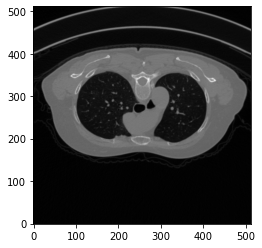

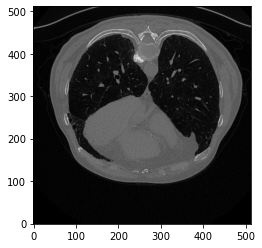

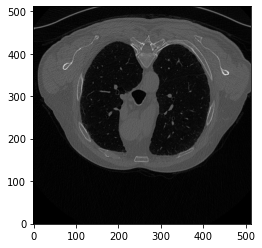

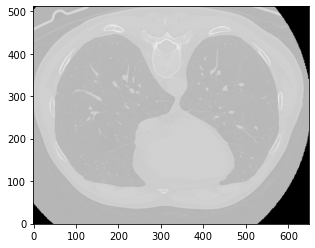

In [3]:
basepath = '../Images/slice*.nii.gz'
paths = sorted(glob.glob(basepath))
print('Images found:', len(paths))

for c, exam_path in enumerate(paths):
    ct_img = nib.load(exam_path)
    ct_numpy = ct_img.get_fdata()
    show_slice(ct_numpy)
    if c == 3:
      break

## Intensidades de TC e unidades Hounsfield

![Escala Hounsfield](https://theaisummer-com.translate.goog/static/083da2c0648b42a83e6bd19b3679b904/c67d4/hounsfield-window.png?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=wapp)

In [9]:
def show_slice_window(slice, level, window):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")
    plt.savefig('../Figures/L'+str(level)+'W'+str(window))

In [10]:
exam_path = paths[1]
ct_img = nib.load(exam_path)
ct_numpy = ct_img.get_fdata()

Imagem completa

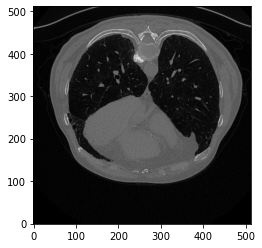

In [11]:
show_slice(ct_numpy)

Ossos

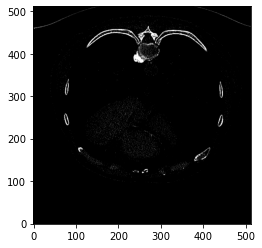

In [12]:
show_slice_window(ct_numpy, 350, 500)

Tecidos

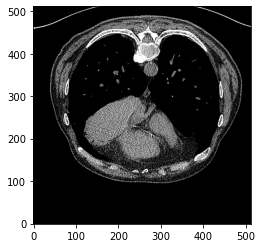

In [13]:
show_slice_window(ct_numpy, 50, 350)

## Segmentação pulmonar com base em valores de intensidade

Metadados

In [14]:
ct_img = nib.load(exam_path)
print(ct_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  2 512 512   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.78515625 0.78515625 1.         1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 206.60742
qoffset_y       : 405.60742
qoffset_z 

### Etapa 1: encontre as dimensões em pixels para calcular a área em mm^2

Gerar dimenções do pulmão em mm² (valores de x e y)

In [15]:
def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"] # example [1,2,1.5,1,1]
    dim = ct_img.header["dim"] # example [1,512,512,1,1]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY] # example [2, 1.5]

In [16]:
find_pix_dim(ct_img)

[0.78515625, 0.78515625]

### Etapa 2: Binarize a imagem usando o limiar de intensidade

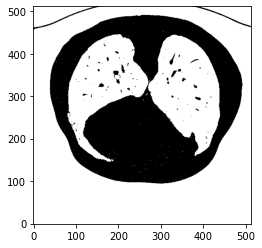

In [17]:
clipped = ct_numpy.clip(-1000, -300)
clipped[clipped != -300] = 1
clipped[clipped == -300] = 0
plt.figure()
plt.imshow(clipped.T, cmap="gray", origin="lower")

### Etapa 3: descoberta de contorno

In [18]:
contours = measure.find_contours(clipped, 0.95)

### Step 4: Encontre a área do pulmão a partir de um conjunto de contornos possíveis

In [19]:
lungs = find_lungs(contours)

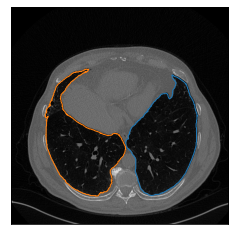

In [20]:
show_contour(ct_numpy, lungs)

### Etapa 5: contorno para máscara binária

In [21]:
lung_mask = create_mask_from_polygon(ct_numpy, lungs)

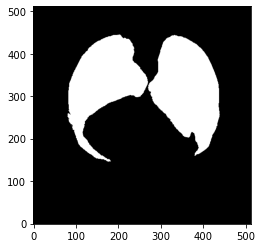

In [22]:
show_slice(lung_mask)

Área do pulmão

In [23]:
lung_area = compute_area(lung_mask, find_pix_dim(ct_img))

In [24]:
print(f'Área do pulmão: {lung_area}mm²')

Área do pulmão: 34572.27296447754mm²


## Segmente os vasos principais e calcule a razão entre os vasos e a área pulmonar

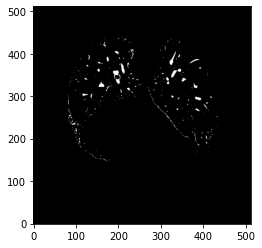

In [25]:
vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs, denoise=False)

### Analisando e melhorando o resultado da segmentação

In [26]:
vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs, denoise=True)

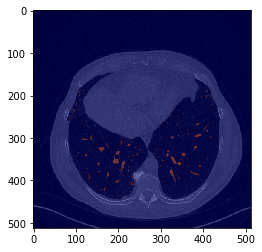

In [27]:
overlay_plot(ct_numpy, vessels_only)

Área dos vasos

In [28]:
vessel_area = compute_area(vessels_only, find_pix_dim(ct_img))
print(f'Área dos vasos: {vessel_area}mm²')

ratio = (vessel_area / lung_area) * 100
print(f'Área dos vasos: {ratio:.2f}%')

Área dos vasos: 1266.8465423583984mm²
Área dos vasos: 3.66%


---

## Análise das imagens e geração dos dados para todas as imagens (fatias)

### Área do pulmão

slice001 lung area: 14218.815117879074
slice002 lung area: 34572.27296447754
slice003 lung area: 31513.963623046875
slice004 lung area: 33388.04453495125
slice005 lung area: 32391.739428426652
slice006 lung area: 32086.478447489502
slice007 lung area: 17640.84075957298
slice008 lung area: 26042.239642517397
slice009 lung area: 31255.91289323208
slice010 lung area: 24475.454391479492
slice011 lung area: 18455.89931488037
slice012 lung area: 25330.21658706665
slice013 lung area: 30042.837661743164
slice014 lung area: 30310.75862121582
slice015 lung area: 25977.577117919922
slice016 lung area: 27387.329864501953
slice017 lung area: 15523.084259033203
slice018 lung area: 29196.441650390625
slice019 lung area: 4298.816299438477
slice020 lung area: 12907.887268066406


C:\Users\darks\AppData\Local\Temp\ipykernel_10384\2626181802.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\darks\AppData\Local\Temp\ipykernel_10384\2626181802.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


slice021 lung area: 11454.214477539062


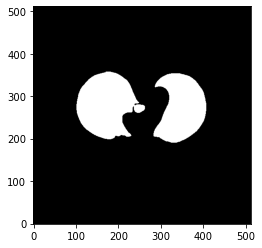

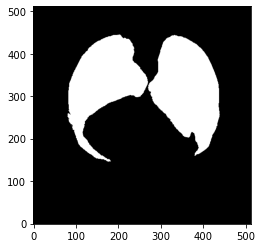

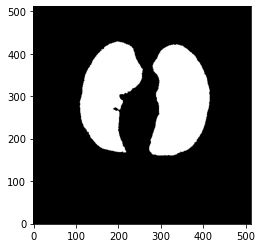

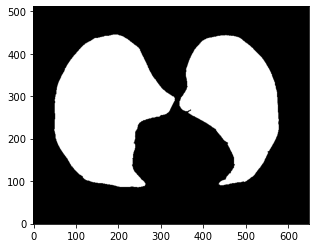

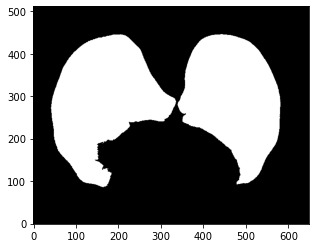

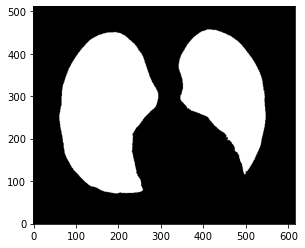

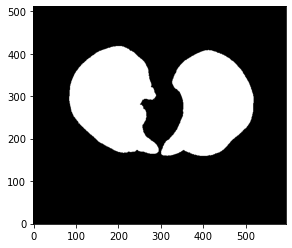

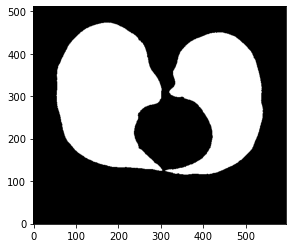

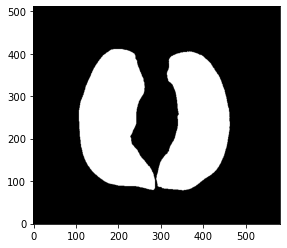

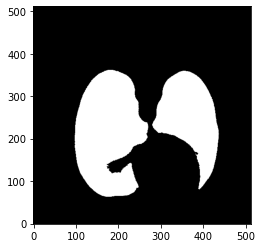

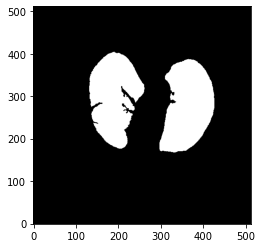

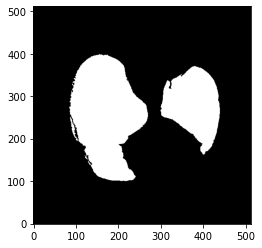

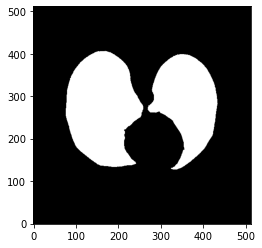

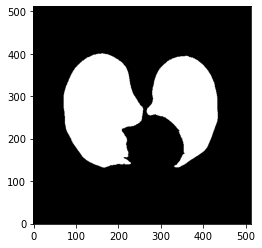

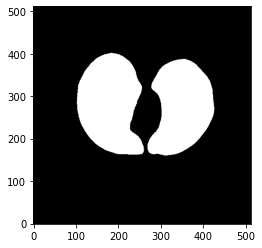

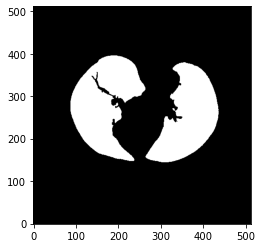

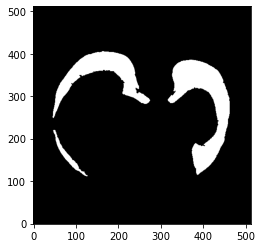

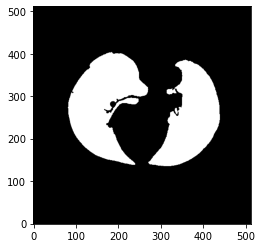

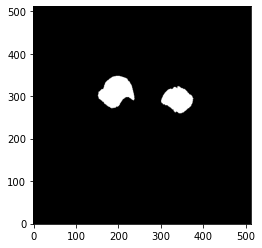

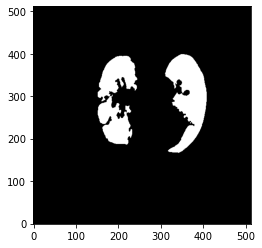

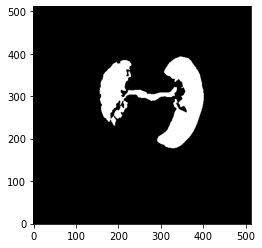

In [29]:
outpath = '../LUNGS/'
contour_path = '../Contours/'
paths = sorted(glob.glob(basepath))
myFile = open('../CSV/lung_volumes.csv', 'w')
lung_areas = []
make_dirs(outpath)
make_dirs(contour_path)

for c, exam_path in enumerate(paths):

    img_name = exam_path.split("/")[-1].split('.nii')[0].split('\\')[-1]
    
    out_mask_name = outpath + img_name + "_mask"
    contour_name = contour_path + img_name + "_contour"

    ct_img = nib.load(exam_path)

    pixdim = find_pix_dim(ct_img)
    
    ct_numpy = ct_img.get_fdata()

    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    lungs = find_lungs(contours)
    
    show_contour(ct_numpy, lungs, contour_name,save=True)

    lung_mask = create_mask_from_polygon(ct_numpy, lungs)

    save_nifty(lung_mask, out_mask_name, ct_img.affine)
    show_slice(lung_mask)

    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))
    lung_areas.append([img_name,lung_area]) # int is ok since the units are already mm^2
    
    print(img_name,'lung area:', lung_area)

# Salva os dados em CSV
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas)

### Vasos

In [33]:
vessels = '../Vessels/'
figures = '../Figures/'
overlay_path = '../Vessel_overlayed/'
paths = sorted(glob.glob(basepath))
myFile = open('../CSV/vessel_volumes.csv', 'w')
lung_areas_csv = []
ratios = []

make_dirs(vessels)
make_dirs(overlay_path)
make_dirs(figures)

for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0].split('\\')[-1]
    vessel_name = vessels + img_name + "_vessel_only_mask"
    overlay_name = overlay_path + img_name + "_vessels"

    ct_img = nib.load(exam_path)
    pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()

    contours = intensity_seg(ct_numpy, -1000, -300)

    lungs_contour = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs_contour)

    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, lungs_contour, denoise=True)

    overlay_plot(ct_numpy, vessels_only)
    plt.title('Overlayed plot')
    plt.savefig(overlay_name)
    plt.close()

    save_nifty(vessels_only, vessel_name, affine=ct_img.affine)

    vessel_area = compute_area(vessels_only, find_pix_dim(ct_img))
    ratio = (vessel_area / lung_area) * 100
    print(img_name, 'Vessel %:', ratio)
    lung_areas_csv.append([img_name, lung_area, vessel_area, ratio])
    ratios.append(ratio)

# Save data to csv file
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas_csv)

slice001 Vessel %: 2.2451221087995865
slice002 Vessel %: 3.6643426472423815
slice003 Vessel %: 2.323943661971831
slice004 Vessel %: 2.712665648385968
slice005 Vessel %: 2.2762854680106246
slice006 Vessel %: 3.126406404105982
slice007 Vessel %: 2.9513865438385585
slice008 Vessel %: 3.808181826499894
slice009 Vessel %: 2.1884959391384804
slice010 Vessel %: 5.3276199473648695
slice011 Vessel %: 3.913929208046855
slice012 Vessel %: 6.098669684769097
slice013 Vessel %: 3.394685023352699
slice014 Vessel %: 2.456570479216736
slice015 Vessel %: 2.576504686264915
slice016 Vessel %: 2.76259480530486
slice017 Vessel %: 4.732002691186365
slice018 Vessel %: 3.48966613672496
slice019 Vessel %: 4.103117829666622
slice020 Vessel %: 7.433960653778859
slice021 Vessel %: 6.309512359334423


### Plots adicionais

Centers 2D: [[13499.9367852    593.63437113]
 [29569.37624489   955.65534174]]
Slice labels: [0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0]


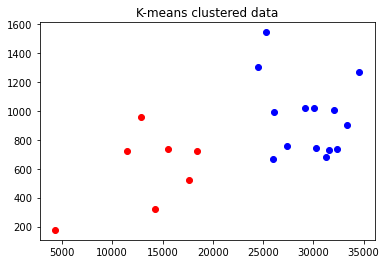

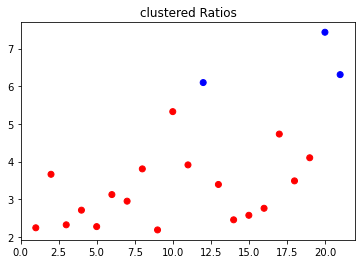

In [35]:
# Data viz here
from sklearn.cluster import KMeans
x, y = split_array_coords(lung_areas_csv, indx=1, indy=2)
data2d = np.stack([np.asarray(x), np.asarray(y)], axis=1)

kmeans = KMeans(init="random", n_clusters=2)
kmeans.fit(data2d)
print('Centers 2D:', kmeans.cluster_centers_)
print('Slice labels:', kmeans.labels_)

class1 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 0]
class2 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 1]

plt.figure()
x, y = split_array_coords(class1)
plt.scatter(x, y, c='r')
x, y = split_array_coords(class2)
plt.scatter(x, y, c='b')
plt.title('K-means clustered data')
plt.savefig('../Figures/kmeans-clustered')

plt.figure()
x, _ = split_array_coords(lung_areas_csv, indx=3, indy=2)
plt.scatter(x, np.arange(len(x)))
plt.title('Ratios of different slices')
plt.savefig('../Figures/Ratios')
plt.close()

# assign categories
categories = np.zeros(len(x), dtype=int)

for c, i in enumerate(x):
    if i > 6:
        categories[c] = int(1)

colormap = np.array(['r', 'b'])

plt.figure()
plt.scatter(np.arange(len(x)) + 1, x, c=colormap[categories])
plt.title('clustered Ratios')
plt.savefig('../Figures/clustered_ratios')